# Correlation

Correlation tests are used to check if two samples are related. They are often used for feature selection and multivariate analysis in data preprocessing and exploration.

## Pearson's Correlation Coefficient

The goal of this test is to answer the question: do two samples have a linear relationship?

To answer this question, we will take the following steps:

1. Calculate the Pearson correlation coefficient 
1. Calculate the corresponding t-values
1. Test whether the t-values are significant or not


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

from scipy import stats
from pydataset import data

In [2]:
url = "https://gist.githubusercontent.com/ryanorsinger/2c13a71421037af127e9fa7fa1463cad/raw/3eb443414078b51af33fdb2d211159e5f3e220ab/exam_scores.csv"
df = pd.read_csv(url)

In [3]:
df.head(3)

,exam_score,hours_studied,study_strategy,handedness,coffee_consumed,hours_slept
0,100.591011,9.126291,flashcards,left,0,11
1,95.637086,9.677438,flashcards,left,1,10
2,53.200296,4.550207,NaN,right,5,6


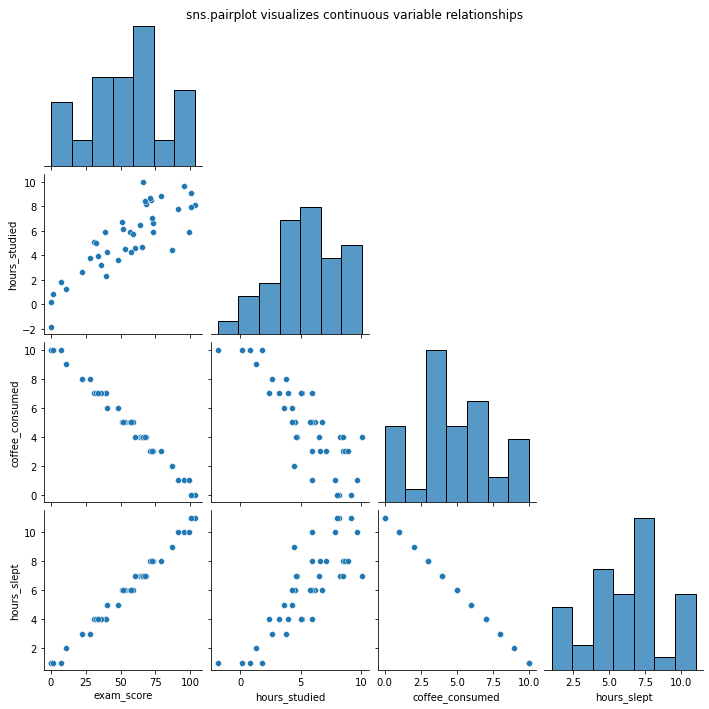

In [4]:
sns.pairplot(df, corner=True)
plt.suptitle("sns.pairplot visualizes continuous variable relationships")
plt.show()

## Pre-set Values

Before we perform the test, we will choose some values for our confidence interval and, based on that value, our alpha.

In [6]:
n = df.shape[0]     # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
alpha = 1 - conf_interval

When performing a correlation test, our null hypothesis is that there is no linear correlation between the two variables.

> H<sub>0</sub>: There is no linear correlation between the number of hours studied and the score on the exam.

> H<sub>a</sub>: There is a linear relationship between the number of hours studied and the score on the exam.

## Calculate Pearson's Correlation Coefficient

The correlation coefficient, **r<sub>xy</sub>** is a unitless continuous numerical measure between -1 and 1, where:

    1 = perfect correlation 

and

    -1 = perfect negative correlation.

We will calculate the correlation between hours studied and exam score.

In [7]:
x = df.hours_studied
y = df.exam_score

def stdev(x):
    variance = ((x - x.mean()) ** 2).sum() / n
    return sqrt(variance)

r_xy = (((x - x.mean()) * (y - y.mean())).sum() / (n)) / (stdev(x) * stdev(y))
r_xy

0.8351498542413306

But how is this number really dervied? Let's simplify our dataframe by looking only at the two variables we are interested in, and we will rename them to `x` and `y`

In [8]:
example = df[['exam_score', 'hours_studied']].rename(columns={'exam_score':'x', 'hours_studied':'y'})
example.head()

,x,y
0,100.591011,9.126291
1,95.637086,9.677438
2,53.200296,4.550207
3,63.934268,6.487848
4,51.186370,6.720959


Because these two variables are quite different in their range, we need to compare each row to the mean for each variable. This will allow us to get a better sense of the movement between these variables from one observation to the next relative to their own means. 

In [9]:
# Calculate the means
x_mean = example.x.mean()
y_mean = example.y.mean()
print(x_mean, y_mean)

55.28336550715703 5.417465533490342


Now we can add a column showing the difference between each observation and its mean for each variable

In [10]:
example['x-x_mean'] = example.x - x_mean
example['y-y_mean'] = example.y - y_mean
example.head()

,x,y,x-x_mean,y-y_mean
0,100.591011,9.126291,45.307646,3.708825
1,95.637086,9.677438,40.353720,4.259972
2,53.200296,4.550207,-2.083070,-0.867259
3,63.934268,6.487848,8.650903,1.070382
4,51.186370,6.720959,-4.096995,1.303494


By multiplying these last two columns together, we can see a hit at the covariance of these variables. When the movements were in the same direction, the final column is positive. When the movements were in opposite directions, the final column was negative. 

In [11]:
example['x-x_mean*y-y_mean'] = example['x-x_mean'] * example['y-y_mean']
example.head()

,x,y,x-x_mean,y-y_mean,x-x_mean*y-y_mean
0,100.591011,9.126291,45.307646,3.708825,168.038152
1,95.637086,9.677438,40.353720,4.259972,171.905736
2,53.200296,4.550207,-2.083070,-0.867259,1.806561
3,63.934268,6.487848,8.650903,1.070382,9.259772
4,51.186370,6.720959,-4.096995,1.303494,-5.340407


We can sum the final column to see the total effect of all these observations

In [12]:
sum_product = sum(example['x-x_mean*y-y_mean'])
print(sum_product)

2615.385681519705


Now we can get a sense of the average per observation.

In [13]:
cov_x_y = sum_product/(example.shape[0])
print(cov_x_y)

65.38464203799262


Great! We can see that there is a positive relationship, but its kind of hard to tell what the magnitude of that relationship is. We can use our covariance and our standard deviations to find the pearsons r, which has the nice limits of -1 and 1. 

To find pearson's r, we simply divide the covariance by the product of the standard deviations of x and y.

In [14]:
corr = cov_x_y / (stdev(example.x) * stdev(example.y))
print(corr)

0.8351498542413301


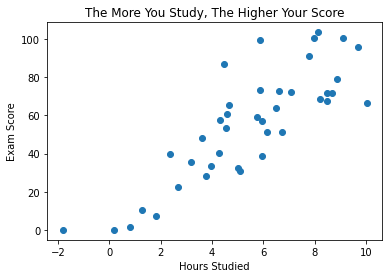

In [15]:
plt.scatter(df.hours_studied, df.exam_score)
plt.title('The More You Study, The Higher Your Score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.show()

## Calculate the corresponding p-value

We can calculate a t-statistic for our correlation coefficient in order to inform us how likely it is that we observed this result due to chance. We will then use this t-statistic to find our p-value.

The t-value can be positive for positive correlations and negative for negative correlations, and is given by:

In [16]:
t = (r_xy * sqrt(n - 2)) / sqrt(1 - r_xy**2)
t

9.359998377263368

Once we have our t-statistic, we can find our p-value by looking up the t-statistic in a t-table, or by using scipy's t distribution:

In [17]:
p = stats.t.sf(t, df=degf) * 2 # *2 for a two-tailed test
p

2.0762953315463266e-11

Lastly, we compare our p value to our alpha that we selected earlier

In [18]:
p < alpha

True

Since p is less than alpha, we reject our null hypothesis that there is no linear correlation between the number of hours studied and exam score.

## The Easy Way

All of the work that we did above is also provided by scipy's `stats` module in it's `pearsonr` function.

In [19]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.8351498542413305, 2.0762953315463534e-11)

## Correlation Gotchas

When working with correlation, keep in mind:

1. Correlation is not causality.
1. Correlation measures linear relationship between the 2 variables. However, there may be other types of relationships, such as a quadratic or absolute value relationship.
1. Correlations can be misleading when confounding variables are ignored.
1. Correlation tells you nothing about how large the relationship is.

### Correlation is Not Causation

Correlation means that two variables are associated, but doesn't tell us whether one causes the other or not.

### Non-Linear Relationship
Here we'll look at an example of a non-linear relationship:

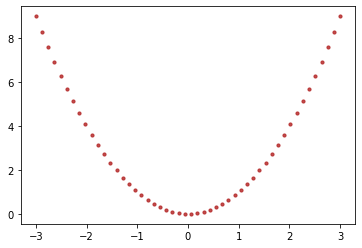

In [20]:
x = np.linspace(-3, 3)
y = x ** 2
plt.scatter(x, y, s=10, c='firebrick', alpha=.8)

We see that there is clearly a direct relationship between x and y, however it is not a linear relationship, so a correlation test will not give us significant results.

In [21]:
r, p = stats.pearsonr(x, y)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')

r = -0.00000
p = 1.0


### Confounding Variables
We must be careful because correlation doesn't tell the whole story of a dataset. That is, correlation just looks at two variables in isolation, and doesn't account for any others. For example, a certain subgroup could have a strong correlation while another does not, or a third variable could be influencing both of the variables.

In our exam score data, if we look at coffee consumption and exam score, we see that they are strongly negatively correlated:

Text(8, 80, 'r = -0.994')

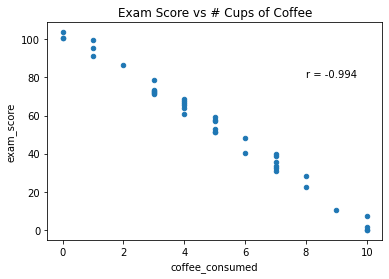

In [22]:
r, p = stats.pearsonr(df.coffee_consumed, df.exam_score)

df.plot.scatter('coffee_consumed', 'exam_score')
plt.title('Exam Score vs # Cups of Coffee')
plt.text(8, 80, f'r = {r:.3f}')

However, it is probably the case that a third variable here has more influence, the number of hours that each student slept before the exam. We know that getting a good night's sleep improves exam scores, and if you don't get a good night's sleep, you are probably likely to drink more coffee.

In [23]:
r_sleep_coffee, _ = stats.pearsonr(df.hours_slept, df.coffee_consumed)
r_sleep_score, _ = stats.pearsonr(df.hours_slept, df.exam_score)

print('Correlation between hours slept and coffee consumed')
print(f'  r = {r_sleep_coffee:.3f}')
print('Correlation between hours slept and exam score')
print(f'  r = {r_sleep_score:.3f}')

Correlation between hours slept and coffee consumed
  r = -1.000
Correlation between hours slept and exam score
  r = 0.994


### Scale of the Relationship
The correlation coefficient shows us how linearly correlated two variables are, but doesn't tell us the scale. That is one variable could increase/decrease in lock step with another, but the size of the change could be tiny.

Imagine our data was a little different and we tracked several student's coffee intake before an exam. The coffee consumption could be perfectly correlated with exam score, but to such a small amount that it doesn't matter.

Text(1, 63, 'p = 0.000000e+00')

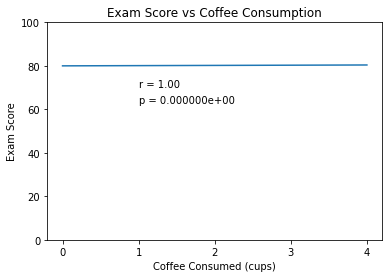

In [24]:
cups_of_coffee = [0, 1, 2, 3, 4]
exam_score = [80, 80.1, 80.2, 80.3, 80.4]
r, p = stats.pearsonr(cups_of_coffee, exam_score)

plt.plot(cups_of_coffee, exam_score)
plt.title('Exam Score vs Coffee Consumption')
plt.ylim(0, 100)
plt.xticks(range(5))
plt.xlabel('Coffee Consumed (cups)')
plt.ylabel('Exam Score')

plt.text(1, 70, f'r = {r:.2f}')
plt.text(1, 63, f'p = {p:e}')

## What about non-linear correlations between variables?
Use Spearman's R, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html for a nonparametric test of linearity, as long as we have monotonicity (as one variable increases, the other variable never decreases and vice versa).